Import librarys

In [3]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [7]:
#enable memory profiler for memory management usage %%memit 
from memory_profiler import memory_usage
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

Audio file loading control flag

In [9]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 
#
# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 
#
SKIP_AUDIO_RELOAD = False

### Dataset exploration

#### Ordner Struktur aus Kaggle Code

input/train/Train/fold1...

#### Ordner Struktur von mir

data/audio/fold1...

In [10]:
INPUT_PATH = 'data'

In [13]:
INPUT_FILE = INPUT_PATH+'/metadata/UrbanSound8K.csv'
AUDIO_DIR = INPUT_PATH+'/audio'

In [11]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    return data

In [14]:
# show info
input = load_input_data(pd, INPUT_FILE)
input.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [20]:
from sklearn.model_selection import train_test_split

train_input, test_input = train_test_split(input, train_size=0.6224)

In [22]:
# labels
valid_train_label = train_input[['class']]
valid_train_label.count()

# unique classes
x = train_input.groupby('class')['class'].count()
x

class
air_conditioner     618
car_horn            255
children_playing    601
dog_bark            632
drilling            645
engine_idling       632
gun_shot            239
jackhammer          619
siren               567
street_music        626
Name: class, dtype: int64

In [23]:
valid_train_data = train_input[['classID', 'class']]
valid_train_data.count()

classID    5434
class      5434
dtype: int64

In [25]:
valid_test_data = test_input[['classID']]
valid_test_data.count()

classID    3298
dtype: int64

### Check input audio file samples

In [32]:
# Siren has iconic spectrogram
train_input[train_input['class']=='siren'].head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
155,102871-8-0-0.wav,102871,0.000000,4.000000,1,2,8,siren
2526,157868-8-0-25.wav,157868,12.500000,16.500000,1,8,8,siren
2746,159751-8-0-3.wav,159751,2.650495,6.650495,2,4,8,siren
8414,91396-8-0-0.wav,91396,121.591247,125.591247,2,2,8,siren
2654,159742-8-0-8.wav,159742,4.129945,8.129945,2,10,8,siren


In [48]:
# sample-1 load -> train_input[155]
sample1 = AUDIO_DIR + '/fold' + str(train_input.loc[train_input['slice_file_name']=='102871-8-0-0.wav', 'fold'].iloc[0]) + '/' + str(train_input.loc[train_input['slice_file_name']=='102871-8-0-0.wav', 'slice_file_name'].iloc[0])
print(sample1)
duration = 2.97
sr = 22050

y, sr = librosa.load(sample1, duration=duration, sr=sr)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

input_length = sr * duration
offset = len(y) - round(input_length)
print('input:', round(input_length), ' load:', len(y), ' offset:', offset)
print('y shape:', y.shape, ' melspec shape:', ps.shape)

data/audio/fold2/102871-8-0-0.wav
input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


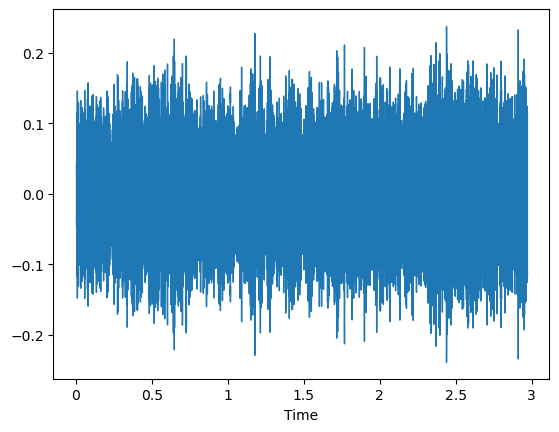

In [55]:
# sample-1 waveplot
librosa.display.waveshow(y) # waveplot gibt es nicht mehr obwohl selbe librose version warum?

In [56]:
# sample-1: audio
import IPython.display as ipd
ipd.Audio(sample1)

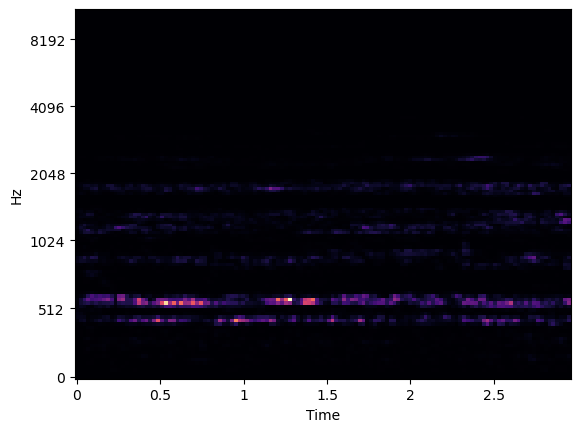

In [57]:
# sample-1: spectrogram
librosa.display.specshow(ps, y_axis='mel', x_axis='time')